# <center>HCDS A1 Assignment</center>
<center>Darshan Mehta</center>

#### Index
1. [Data Acquisition](#Data-Acquisition)
2. [Data Processing](#Data-Processing)
3. [Data Analysis](#Data-Analysis)

In [1]:
import json
import requests

import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

### Data Acquisition

Declare the start and end dates for acquiring the data for both Legacy and Pageviews API.

In [2]:
start_legacy = '2008010100'
end_legacy = '2016080100'

start_pageviews = '2015070100'
end_pageviews = '2019090100'

Declare the endpoints for both Legacy and Pageviews API.

In [3]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Declare the header required for the API calls.

In [4]:
headers = {
    'User-Agent': 'https://github.com/darshanmehta17',
    'From': 'darshanm@uw.edu'
}

Declare the parameters for the calls. Here we specify the ```agent=user``` parameter in Pageviews API call in order to omit views from web crawlers or spiders.

In [5]:
# Legacy Pagecounts params
params_legacy = {"project" : "en.wikipedia.org", 
                 "access-site" : "<access-site>", 
                 "granularity" : "monthly", 
                 "start" : start_legacy, 
                 "end" : end_legacy 
                }

# Pageviews params
params_pageviews = {"project" : "en.wikipedia.org", 
                    "access" : "<access>",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : start_pageviews,
                    "end" : end_pageviews
                   }

Declare the function to fetch the data from the API.

In [6]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Fetch and save the data from the Legacy Pagecounts API.

In [7]:
# Declare the different access types for Legacy Pagecounts API
legacy_accesstypes = ['desktop-site', 'mobile-site']

# Declare output file placeholder
legacy_outputfile = './pagecounts_{}_200801-201607.json'

# Fetch and save the data
for accesstype in legacy_accesstypes:
    params = params_legacy
    params['access-site'] = accesstype
    
    # Fetch the data using the API call function
    response = api_call(endpoint_legacy, params)
    
    # Save the data
    with open(legacy_outputfile.format(accesstype), 'w') as outfile:
        json.dump(response, outfile)

Fetch and save the data from the Pageviews API.

In [8]:
# Declare the different access types for Pageviews API
pageviews_accesstypes = ['desktop', 'mobile-app', 'mobile-web']

# Declare output file placeholder
pageviews_outputfile = './pageviews_{}_201507-201908.json'

# Fetch and save the data
for accesstype in pageviews_accesstypes:
    params = params_pageviews
    params['access'] = accesstype
    
    # Fetch the data using the API call function
    response = api_call(endpoint_pageviews, params)
    
    # Save the data
    with open(pageviews_outputfile.format(accesstype), 'w') as outfile:
        json.dump(response, outfile)

### Data Processing

Create a function to read the JSON files into a Pandas Dataframe and process it.

In [9]:
def read_json_as_pd(filepath):
    # Read the file and convert into dataframe
    json_file = pd.read_json(filepath)
    raw_data = pd.io.json.json_normalize(json_file['items'])
    
    # Drop the unnecessary columns and rename count in 
    # pagecounts to views for uniformity
    if 'count' in raw_data.columns:
        processed_data = raw_data[['count', 'timestamp']].copy()
        processed_data = processed_data.rename(columns={'count': 'views'})
    else:
        processed_data = raw_data[['views', 'timestamp']].copy()
    
    # Keep only the year and month values in the timestamp
    processed_data['timestamp'] = processed_data['timestamp'].apply(lambda x: x[:6])
    
    # Make timestamp the key to simplify downstream processing
    processed_data = processed_data.set_index('timestamp')
        
    return processed_data

Read the JSON file as dataframes and process them.

In [10]:
# Read Legacy Pagecounts JSON.
pagecounts_desktop = read_json_as_pd('./pagecounts_desktop-site_200801-201607.json')
pagecounts_mobile = read_json_as_pd('./pagecounts_mobile-site_200801-201607.json')

# Read Pageviews JSON.
pageviews_desktop = read_json_as_pd('./pageviews_desktop_201507-201908.json')
pageviews_mobile_app = read_json_as_pd('./pageviews_mobile-app_201507-201908.json')
pageviews_mobile_web = read_json_as_pd('./pageviews_mobile-web_201507-201908.json')

Now create the final dataframe with the following columns:
- year
- month
- pagecount_all_views
- pagecount_desktop_views
- pagecount_mobile_views
- pageview_all_views
- pageview_desktop_views
- pageview_mobile_views

Steps:
1. For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
2. For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM).
3. For all months with 0 pageviews for a given access method (e.g. desktop-site, mobile-app), that value for that (column, month) should be listed as 0. 

In order to simplify the work for the last step, we iterate over year and months and pick from each dataset if the value for the date in present and fill with 0 if the data for that date is absent.

In [11]:
final_data = []

# Iterate over the months in the range and create the values for the above-listed columns
for date in pd.date_range(start_legacy[:-2], end_pageviews[:-2], freq='M'):
    row = {'year': str(date.year), 'month': '{:02d}'.format(date.month)}
    index_item = row['year'] + row['month']
    
    def get_views(df, index_item):
        return df.loc[index_item, 'views'] if index_item in df.index else 0
    
    row['pagecount_desktop_views'] = get_views(pagecounts_desktop, index_item)
    row['pagecount_mobile_views'] = get_views(pagecounts_mobile, index_item)
    row['pagecount_all_views'] = row['pagecount_desktop_views'] + row['pagecount_mobile_views']
    
    row['pageview_desktop_views'] = get_views(pageviews_desktop, index_item)
    # Combine the mobile app and mobile web traffic count into a single 'mobile view'
    row['pageview_mobile_views'] = get_views(pageviews_mobile_app, index_item) + \
                                   get_views(pageviews_mobile_web, index_item)
    row['pageview_all_views'] = row['pageview_desktop_views'] + row['pageview_mobile_views']
    
    final_data.append(row)
    
final_data = pd.DataFrame(final_data).reindex(columns=['year', 'month', 
                                                       'pagecount_all_views', 
                                                       'pagecount_desktop_views', 
                                                       'pagecount_mobile_views', 
                                                       'pageview_all_views', 
                                                       'pageview_desktop_views', 
                                                       'pageview_mobile_views'])

Save the dataframe to CSV and display a sample of it.

In [12]:
# Save the dataframe to csv
final_data.to_csv('en-wikipedia_traffic_200801-201908.csv', index=False)

final_data.head(10)

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4930902570,4930902570,0,0,0,0
1,2008,02,4818393763,4818393763,0,0,0,0
2,2008,03,4955405809,4955405809,0,0,0,0
3,2008,04,5159162183,5159162183,0,0,0,0
4,2008,05,5584691092,5584691092,0,0,0,0
5,2008,06,5712104279,5712104279,0,0,0,0
6,2008,07,5306302874,5306302874,0,0,0,0
7,2008,08,5140155519,5140155519,0,0,0,0
8,2008,09,5479533823,5479533823,0,0,0,0
9,2008,10,5679440782,5679440782,0,0,0,0


### Data Analysis

Create a new date column for the plot by combining year and month and convert to datetime format. This new column will become the x axis of the plot.

In [19]:
final_data['date'] = final_data['year'] + final_data['month'] + '01'
final_data['date'] = pd.to_datetime(final_data['date'])

Divide all the view counts by $10^{6}$ for making it easy to read in the graph.

In [39]:
for column in ['pagecount_all_views', 'pagecount_desktop_views', 
               'pagecount_mobile_views', 'pageview_all_views', 
               'pageview_desktop_views', 'pageview_mobile_views']:
    final_data[column] = final_data[column] / 1e6

Create a function to return only non-zero rows of a column for plotting purposes. This will prevent unnecessary scaling of the graph and help us to focus on the points which make sense.

In [40]:
def get_non_zero_data(df, column):
    return df[df[column] != 0]

Plot the data.

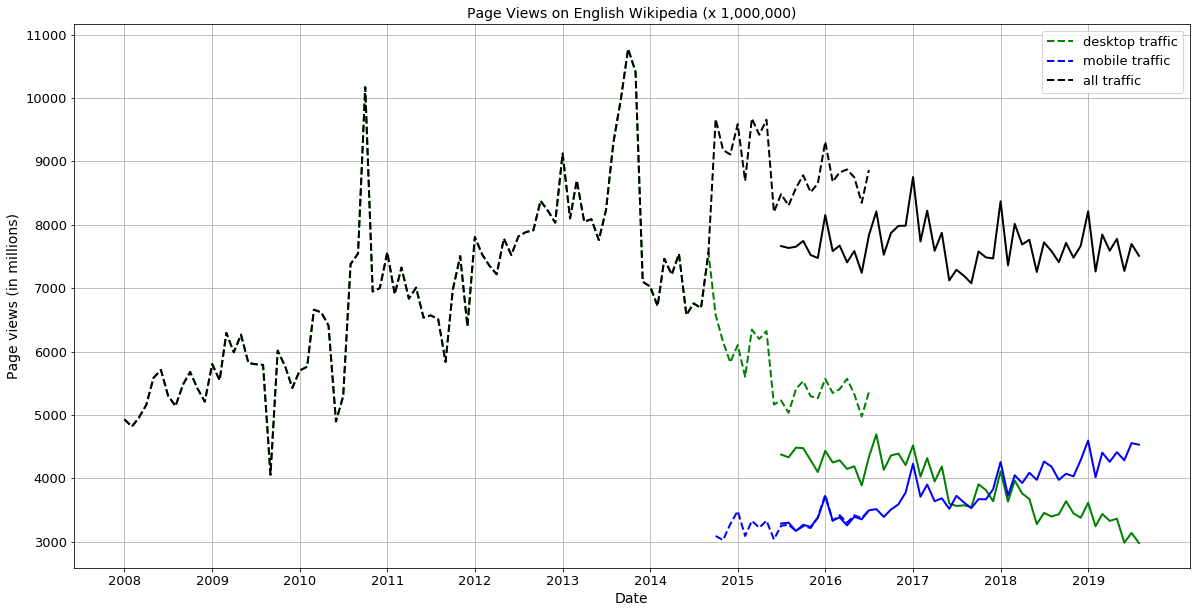

In [64]:
# Set figure size
plt.rcParams['figure.figsize'] = [20, 10]

# Desktop Traffic
plt.plot('date', 'pagecount_desktop_views', data=get_non_zero_data(final_data, 'pagecount_desktop_views'), 
         color='green', linewidth=2, linestyle='dashed', label="desktop traffic")
plt.plot('date', 'pageview_desktop_views', data=get_non_zero_data(final_data, 'pageview_desktop_views'), 
         color='green', linewidth=2, label="")

# Mobile Traffic
plt.plot('date', 'pagecount_mobile_views', data=get_non_zero_data(final_data, 'pagecount_mobile_views'), 
         color='blue', linewidth=2, linestyle='dashed', label="mobile traffic")
plt.plot('date', 'pageview_mobile_views', data=get_non_zero_data(final_data, 'pageview_mobile_views'), 
         color='blue', linewidth=2, label="")

# All Traffic
plt.plot('date', 'pagecount_all_views', data=get_non_zero_data(final_data, 'pagecount_all_views'), 
         color='black', linewidth=2, linestyle='dashed', label="all traffic")
plt.plot('date', 'pageview_all_views', data=get_non_zero_data(final_data, 'pageview_all_views'), 
         color='black', linewidth=2, label="")

# Set the x values to be each year
x = sorted(pd.to_datetime(final_data['year']).unique())
_ = plt.xticks(x)

# Display the grid
plt.grid(True)

# Set the legend
_ = plt.legend(prop={'size':13})

# Set font sizes
plt.tick_params(labelsize=13)


# Set the axis label and title of the plot
plt.xlabel('Date', fontsize=14)
plt.ylabel('Page views (in millions)', fontsize=14)
plt.title('Page Views on English Wikipedia (x 1,000,000)', fontsize=14)

# Save the figure to disk
plt.savefig('en-wikipedia_traffic_200801-201908.png')

#### Interpretation of the plot
The above plot depicts the page views counted on the English Wikipedia page between Jan 2018 and Aug 2019. Since July 2015, a new page view definition took effect, which identified all crawler traffic and the new API provided means to elimite this segment of views. The solid lines mark the new definition and the dotted mark the old definition. There was a period in which both the APIs were in function and we can notice that the solid line is below the dotted line, denoting the omission of crawler traffic in the counts.

### _Fin._